# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [2]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import random

import thinkstats2
import thinkplot

## Least squares

One more time, let's load up the NSFG data.

In [3]:
import first
live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
ages = live.agepreg
weights = live.totalwgt_lb

The following function computes the intercept and slope of the least squares fit.

In [4]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope

Here's the least squares fit to birth weight as a function of mother's age.

In [5]:
inter, slope = LeastSquares(ages, weights)
inter, slope

(6.8303969733110526, 0.017453851471802756)

The intercept is often easier to interpret if we evaluate it at the mean of the independent variable.

In [6]:
inter + slope * 25

7.2667432601061215

And the slope is easier to interpret if we express it in pounds per decade (or ounces per year).

In [7]:
slope * 10

0.17453851471802756

The following function evaluates the fitted line at the given `xs`.

In [8]:
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

And here's an example.

In [9]:
fit_xs, fit_ys = FitLine(ages, inter, slope)

Here's a scatterplot of the data with the fitted line.

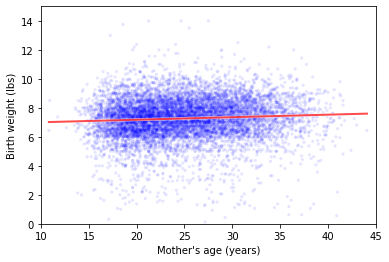

In [10]:
thinkplot.Scatter(ages, weights, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Birth weight (lbs)',
                 axis=[10, 45, 0, 15],
                 legend=False)

## Residuals

The following functon computes the residuals.

In [11]:
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

Now we can add the residuals as a column in the DataFrame.

In [12]:
live['residual'] = Residuals(ages, weights, inter, slope)

To visualize the residuals, I'll split the respondents into groups by age, then plot the percentiles of the residuals versus the average age in each group.

First I'll make the groups and compute the average age in each group.

In [13]:
bins = np.arange(10, 48, 3)
indices = np.digitize(live.agepreg, bins)
groups = live.groupby(indices)

age_means = [group.agepreg.mean() for _, group in groups][1:-1]
age_means

[15.212333333333312,
 17.74035928143719,
 20.506304824561838,
 23.455752212389893,
 26.435156146179903,
 29.411177432543294,
 32.30232530120497,
 35.240273631840736,
 38.10876470588231,
 40.91205882352941]

Next I'll compute the CDF of the residuals in each group.

In [14]:
cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

The following function plots percentiles of the residuals against the average age in each group.

In [15]:
def PlotPercentiles(age_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(age_means, weight_percentiles, label=label)

The following figure shows the 25th, 50th, and 75th percentiles.

Curvature in the residuals suggests a non-linear relationship.

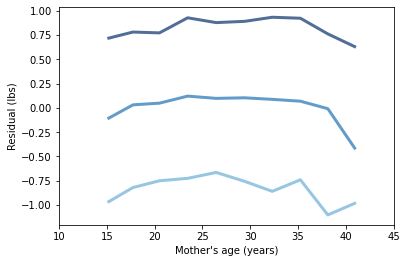

In [16]:
PlotPercentiles(age_means, cdfs)

thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

## Sampling distribution

To estimate the sampling distribution of `inter` and `slope`, I'll use resampling.

In [17]:
def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.

    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement

    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    """Resamples rows from a DataFrame.

    df: DataFrame

    returns: DataFrame
    """
    return SampleRows(df, len(df), replace=True)

The following function resamples the given dataframe and returns lists of estimates for `inter` and `slope`.

In [18]:
def SamplingDistributions(live, iters=101):
    t = []
    for _ in range(iters):
        sample = ResampleRows(live)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = LeastSquares(ages, weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

Here's an example.

In [19]:
inters, slopes = SamplingDistributions(live, iters=1001)

The following function takes a list of estimates and prints the mean, standard error, and 90% confidence interval.

In [20]:
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

Here's  the summary for `inter`.

In [21]:
Summarize(inters)

mean, SE, CI 6.828666879429034 0.06912468898559271 (6.707885506555074, 6.942011969334983)


And for `slope`.

In [22]:
Summarize(slopes)

mean, SE, CI 0.01755342950866741 0.0027150106307997023 (0.013271965247076063, 0.022114805363007424)


**Exercise:** Use `ResampleRows` and generate a list of estimates for the mean birth weight.  Use `Summarize` to compute the SE and CI for these estimates.

In [22]:
# Solution goes here

## Visualizing uncertainty

To show the uncertainty of the estimated slope and intercept, we can generate a fitted line for each resampled estimate and plot them on top of each other.

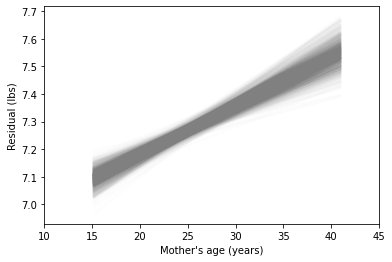

In [23]:
for slope, inter in zip(slopes, inters):
    fxs, fys = FitLine(age_means, inter, slope)
    thinkplot.Plot(fxs, fys, color='gray', alpha=0.01)
    
thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

Or we can make a neater (and more efficient plot) by computing fitted lines and finding percentiles of the fits for each value of the dependent variable.

In [24]:
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = FitLine(xs, inter, slope)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)

This example shows the confidence interval for the fitted values at each mother's age.

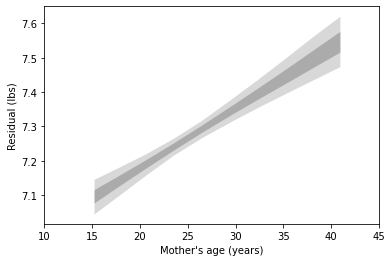

In [25]:
PlotConfidenceIntervals(age_means, inters, slopes, percent=90, 
                        color='gray', alpha=0.3, label='90% CI')
PlotConfidenceIntervals(age_means, inters, slopes, percent=50,
                        color='gray', alpha=0.5, label='50% CI')

thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

## Coefficient of determination



The coefficient compares the variance of the residuals to the variance of the dependent variable.

In [26]:
def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

For birth weight and mother's age $R^2$ is very small, indicating that the mother's age predicts a small part of the variance in birth weight.

In [27]:
inter, slope = LeastSquares(ages, weights)
res = Residuals(ages, weights, inter, slope)
r2 = CoefDetermination(weights, res)
r2

0.004738115474710702

We can confirm that $R^2 = \rho^2$:

In [28]:
print('rho', thinkstats2.Corr(ages, weights))
print('R', np.sqrt(r2))    

rho 0.06883397035410908
R 0.06883397035411151


To express predictive power, I think it's useful to compare the standard deviation of the residuals to the standard deviation of the dependent variable, as a measure RMSE if you try to guess birth weight with and without taking into account mother's age.

In [29]:
print('Std(ys)', Std(weights))
print('Std(res)', Std(res))

Std(ys) 1.40821553384062
Std(res) 1.404875428785783


As another example of the same idea, here's how much we can improve guesses about IQ if we know someone's SAT scores.

In [30]:
var_ys = 15**2
rho = 0.72
r2 = rho**2
var_res = (1 - r2) * var_ys
std_res = np.sqrt(var_res)
std_res

10.409610943738484

## Hypothesis testing with slopes

Here's a `HypothesisTest` that uses permutation to test whether the observed slope is statistically significant.

In [31]:
class SlopeTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        ages, weights = data
        _, slope = thinkstats2.LeastSquares(ages, weights)
        return slope

    def MakeModel(self):
        _, weights = self.data
        self.ybar = weights.mean()
        self.res = weights - self.ybar

    def RunModel(self):
        ages, _ = self.data
        weights = self.ybar + np.random.permutation(self.res)
        return ages, weights

And it is.

In [32]:
ht = SlopeTest((ages, weights))
pvalue = ht.PValue()
pvalue

0.0

Under the null hypothesis, the largest slope we observe after 1000 tries is substantially less than the observed value.

In [33]:
ht.actual, ht.MaxTestStat()

(0.017453851471802756, 0.008723794642346907)

We can also use resampling to estimate the sampling distribution of the slope.

In [34]:
sampling_cdf = thinkstats2.Cdf(slopes)

The distribution of slopes under the null hypothesis, and the sampling distribution of the slope under resampling, have the same shape, but one has mean at 0 and the other has mean at the observed slope.

To compute a p-value, we can count how often the estimated slope under the null hypothesis exceeds the observed slope, or how often the estimated slope under resampling falls below 0.

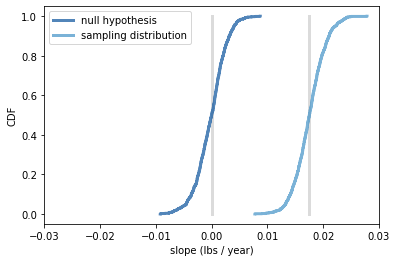

In [35]:
thinkplot.PrePlot(2)
thinkplot.Plot([0, 0], [0, 1], color='0.8')
ht.PlotCdf(label='null hypothesis')

thinkplot.Cdf(sampling_cdf, label='sampling distribution')

thinkplot.Config(xlabel='slope (lbs / year)',
                   ylabel='CDF',
                   xlim=[-0.03, 0.03],
                   legend=True, loc='upper left')

Here's how to get a p-value from the sampling distribution.

In [36]:
pvalue = sampling_cdf[0]
pvalue

0

## Resampling with weights

Resampling provides a convenient way to take into account the sampling weights associated with respondents in a stratified survey design.

The following function resamples rows with probabilities proportional to weights.

In [37]:
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

We can use it to estimate the mean birthweight and compute SE and CI.

In [38]:
iters = 100
estimates = [ResampleRowsWeighted(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.34736556760345 0.0134658350065967 (7.3252102235007746, 7.369301836689533)


And here's what the same calculation looks like if we ignore the weights.

In [39]:
estimates = [thinkstats2.ResampleRows(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.26529700984731 0.013658898802961764 (7.244191192741757, 7.289735007745076)


The difference is non-negligible, which suggests that there are differences in birth weight between the strata in the survey.

# Exercises 10.1

**Exercise:** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

Read the BRFSS data and extract heights and log weights.

In [40]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

Estimate intercept and slope.

In [48]:
# First I will estimate the inercept and slope of the log(weight) 
# versus height by setting the intercept and slope equal to the
# thinkstats2. leastsquares for our datas heights and log weight as
# seen in line In [5] above which was similar to this line of code.

inter, slope = thinkstats2.LeastSquares(heights, log_weights)
inter, slope

(0.993080416391812, 0.005281454169417809)

Make a scatter plot of the data and show the fitted line.

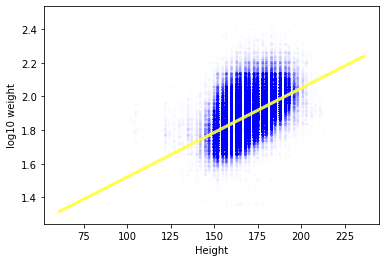

In [68]:
# First we will define our fit the line which will allow us to 
#fit the line for our heights and log_weights then create a scatter 
# plot from our findings 

def FitLine(heights, inter, slope):
    fxs = np.sort(heights)
    fys = inter + slope * fxs
    return fxs, fys

fxs, fys = FitLine(heights, inter, slope)

thinkplot.Scatter(heights, log_weights, alpha=0.01, s=10)
thinkplot.Plot(fxs, fys, color='white', linewidth=3)
thinkplot.Plot(fxs, fys, color='yellow')
thinkplot.Config(xlabel='Height',
                 ylabel='log10 weight',
                 legend=False)

Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.

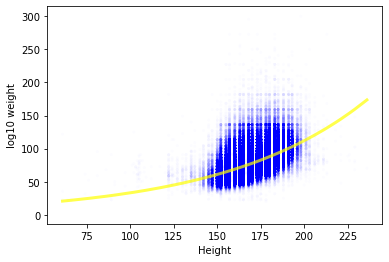

In [72]:
# First we will define our fit the line which will allow us to 
#fit the line for our heights and weights  and set the 10**fys then create a scatter 
# plot from our findings as seen below

def FitLine(heights, inter, slope):
    fxs = np.sort(heights)
    fys = inter + slope * fxs
    return fxs, fys

fxs, fys = FitLine(heights, inter, slope)

thinkplot.Scatter(heights, weights, alpha=0.01, s=10)
thinkplot.Plot(fxs, fys, color='white', linewidth=3)
thinkplot.Plot(fxs, 10**fys, color='yellow')
thinkplot.Config(xlabel='Height',
                 ylabel='log10 weight',
                 legend=False)

Plot percentiles of the residuals.

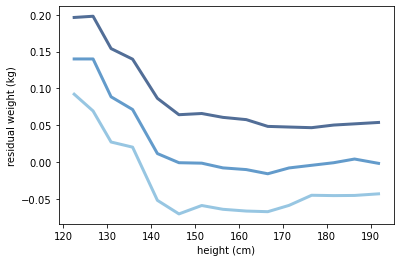

In [79]:
# As seeen below I definded the residual and plotted the heights and 
# log-weight.
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

df['residual'] = Residuals(heights, log_weights, inter, slope)

bins = np.arange(120, 200, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

means = [group.htm3.mean() for i, group in groups][1:-1]
means

cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

PlotPercentiles(means, cdfs)

thinkplot.Config(xlabel="height (cm)",
                 ylabel='residual weight (kg)',
                 legend=False)
# As seen below we see that the lines take a fast dip and then level off
# which shows a slight linear relationship as the hight goes up and weight 
# goes down

Compute correlation.

In [80]:
# We will calculate the rho as seen in the examples above by using the 
# thinkstats2.Corr and using the heights and log weight.

rho = thinkstats2.Corr(heights, log_weights)
rho

0.5317282605983437

Compute coefficient of determination.

In [81]:
# Solution goes here
r2 = rho**2
r2

0.28273494311894004

Confirm that $R^2 = \rho^2$.

In [82]:
# We will confirm that r2 is equal to p2 by setting r2 minus the rho**2
p2_confirm = r2-rho**2
p2_confirm

0.0

Compute Std(ys), which is the RMSE of predictions that don't use height.

In [83]:
# When computing the Std(ys) we can use log_weights and the 
# thinkstat2 std to receive our calculation

stdys = thinkstats2.Std(log_weights)
stdys

0.103207250300049

Compute Std(res), the RMSE of predictions that do use height.

In [84]:
# Next the Std(res) can be easily calculated by useing the 
#thinkstats2.std and setting it to the res

stdres = thinkstats2.Std(res)
stdres

1.404875428785783

How much does height information reduce RMSE?

In [85]:
# Next we can determine how much height information reduces RMSE by 
# taking 1 and minusing it by the stdres and the dividing it by stdys.

RMSEreduce = 1 - stdres / stdys
RMSEreduce

-12.612177678423393

Use resampling to compute sampling distributions for inter and slope.

In [90]:
# First we will create a for loop that will resample and compute the 
# distributions for the inters and the slope of the distribution
dist = []
for _ in range(200):
    re_samp = thinkstats2.ResampleRows(df)
    least_est = thinkstats2.LeastSquares(re_samp.htm3, 
                                         np.log10(re_samp.wtkg2))
    dist.append(least_est)

inters, slopes = zip(*dist)

Plot the sampling distribution of slope.

{'xscale': 'linear', 'yscale': 'linear'}

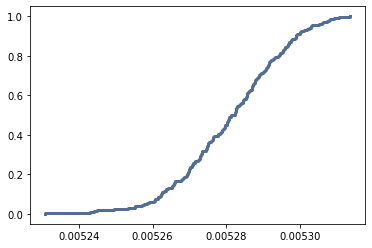

In [91]:
# Next we will plot the sampling distribution of slope by taking the 
# thinkstats2.CDF and setting it to the slopes
sampling_cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(sampling_cdf)

Compute the p-value of the slope.

In [92]:
# The p-value of the slope can be calculate as done at In[36] by 
# setting the sampling_cdf to zero as done above and now below

solution_pvalue = sampling_cdf[0]
solution_pvalue

0

Compute the 90% confidence interval of slope.

In [94]:
# Next I will plot the confidence interval of the slope by setting 
#the sampling_cdf.percentile to 90
coninter = cdf.Percentile(90)
coninter

0.005303222468758684

Compute the mean of the sampling distribution.

In [95]:
# The mean of the samppling distribution can be calculated by setting the 
# thinkstats2.Mean to the slopes which will give us the mean of the 
# sampling distribution


sample_mean = thinkstats2.Mean(slopes)
sample_mean

0.005281035326024636

Compute the standard deviation of the sampling distribution, which is the standard error.

In [96]:
# Next we can compute the standard deviation of the sampling distribution 
# be calculated by setting the thinkstats2.Std to the slopes which will 
# give us the standard deviation or also known as the standard error.

standarderror = thinkstats2.Std(slopes)
standarderror

1.4403043590925084e-05

Resample rows without weights, compute mean height, and summarize results.

In [98]:
# We can resample rows without the weights and copute the mean height by
# setting without weights equal to the thinkstats2.resamplerows to the 
# data frame and htm3 to the mean with a for loop and them summarize.
without_weights = [thinkstats2.ResampleRows(df).htm3.mean() 
                   for _ in range(200)]
Summarize(without_weights)

mean, SE, CI 168.956228842034 0.015064700861272883 (168.92866418076355, 168.97934729885407)


Resample rows with weights.  Note that the weight column in this dataset is called `finalwt`.

In [99]:
# Next we will resample with weights by using the same format but with
# weighted and the finalwt
with_weights = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() 
                for _ in range(100)]
Summarize(with_weights)

mean, SE, CI 170.4963182865458 0.017301482416706118 (170.46516704056268, 170.5239722912751)
